In [1]:
import netCDF4 as nc
import xarray as xr
import os
import glob

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

In [2]:
class ICONGrid:
    @staticmethod
    def save_as_gpkg(gdf, filename, layer):
        gdf.to_file(filename=filename, layer=layer, driver="GPKG")

    def __init__(self, grid_file, var_file):
        self.ds_grid = xr.open_dataset(grid_file)
        self.ds_vars = xr.open_dataset(var_file)

        self._set_height_info(var_file)
        self._load_parent(grid_file)

        self.cells = self.ds_grid.sizes['cell']
        self.gdf_triangles = self._load_triangles()

    def _set_height_info(self, var_file):
        var_file_name = var_file.split('/')[-1]
        if 'ml' in var_file_name:
            self.height_full = self.ds_vars.sizes.get('height')
            self.height_half = self.ds_vars.sizes.get('height_2')
        elif 'pl' in var_file_name:
            self.height_full = self.ds_vars.sizes.get('plev')
            self.height_half = None
        else:
            raise ValueError("Cannot determine height dimension from filename.")

    def _load_parent(self, grid_file):
        try:
            grid_file_parts = grid_file.split('.')
            parent_file = f'{grid_file_parts[0]}.parent.{grid_file_parts[1]}'
            self.ds_parent = nc.Dataset(parent_file)
        except:
            self.ds_parent = None
            print('Parent file not found.')

    def _load_triangles(self):
        lat = np.rad2deg(self.ds_grid['clat_vertices'].values)
        lon = np.rad2deg(self.ds_grid['clon_vertices'].values)
        lat_centers = np.rad2deg(self.ds_grid["lat_cell_centre"].values)
        lon_centers = np.rad2deg(self.ds_grid["lon_cell_centre"].values)

        self.extent = {
            'lon_min': lon.min(), 'lat_min': lat.min(),
            'lon_max': lon.max(), 'lat_max': lat.max()
        }

        polygons = [Polygon([(lon[i][j], lat[i][j]) for j in range(3)]) for i in range(len(lat))]

        gdf = gpd.GeoDataFrame({
            'cell_id': np.arange(1, self.cells + 1),
            'clat': np.rad2deg(self.ds_grid['clat'].values),
            'clon': np.rad2deg(self.ds_grid['clon'].values),
            'geometry': polygons,
            'center_geom': [Point(x, y) for x, y in zip(lon_centers, lat_centers)]
        }, crs="EPSG:4326")

        return gdf

    def get_triangles(self):
        return self.gdf_triangles

    def get_variable(self, param):
        return self.ds_vars[param].values


In [ ]:
class ICONSelect:
    def __init__(self, grid_path, var_path, var_name, time_index=0, height_index=0):
        self.icon = ICONGrid(grid_path, var_path)
        self.gdf = self.icon.get_triangles()
        self.time = self.icon.ds_vars.coords["time"].values
        self.height_dim = self._infer_height_dim(var_name)
        self.var_name = var_name
        self.time_index = time_index
        self.height_index = height_index

        self.data = self.icon.get_variable(var_name)
        self.xr = xr.Dataset(
            {
                var_name: (["time", self.height_dim, "cell"], self.data)
            },
            coords={
                "time": self.icon.ds_vars.coords["time"],
                self.height_dim: self.icon.ds_vars.coords[self.height_dim],
                "cell": np.arange(self.data.shape[2])
            }
        )

        self.xr = self.xr.assign_coords(
            center_lon=("cell", self.gdf["clon"].values),
            center_lat=("cell", self.gdf["clat"].values)
        )
        
    def _infer_height_dim(self, var_name):
        dims = self.icon.ds_vars[var_name].dims
        for d in dims:
            if d.startswith("plev") or d.startswith("height"):
                return d
        raise ValueError(f"No height dimension found for variable '{var_name}'")

    def get_slice_as_gdf(self):
        xr_slice = self.xr.isel(time=self.time_index, **{self.height_dim: self.height_index})
        values = xr_slice[self.var_name].values

        gdf_out = self.gdf.copy()
        gdf_out[self.var_name] = values
        gdf_out.set_geometry("geometry", inplace=True) 
        return gdf_out


    
    @staticmethod
    def get_relation(large_file, small_file, name_large="large", name_small="small"):
        centers = gpd.GeoDataFrame(
            small_file[["cell_id"]].copy(),
            geometry=small_file["center_geom"],
            crs=small_file.crs
        )

        joined = gpd.sjoin(
            centers,
            large_file[["cell_id", "geometry"]],
            predicate="within",
            how="inner"
        )

        joined = joined[["cell_id_left", "cell_id_right"]].rename(columns={
            "cell_id_left": f"cell_id_{name_small}",
            "cell_id_right": f"cell_id_{name_large}"
        })

        return joined

    @staticmethod
    def aggregate_to_large(gdf_small, gdf_large, relation_df, var_name, name_large="large", name_small="small"):
        relation_df = relation_df.rename(columns={
            f"cell_id_{name_small}": "cell_id",
            f"cell_id_{name_large}": f"cell_id_{name_large}"
        })
        merged = gdf_small.merge(relation_df[["cell_id", f"cell_id_{name_large}"]], on="cell_id", how="left")
        merged = merged[["cell_id", f"cell_id_{name_large}", var_name]]

        mean_values = merged.groupby(f"cell_id_{name_large}")[var_name].mean().reset_index()
        mean_values = mean_values.rename(columns={var_name: f"mean_{var_name}"})

        gdf_large_geom = gdf_large[["cell_id", "geometry"]].rename(columns={"cell_id": f"cell_id_{name_large}"})
        mean_grid = mean_values.merge(gdf_large_geom, on=f"cell_id_{name_large}", how="left")
        mean_grid = gpd.GeoDataFrame(mean_grid, geometry="geometry", crs="EPSG:4326")

        return mean_grid

    @staticmethod
    def clip_grid(mean_grid, xr_large_slice, var_name, plot=True):
        xr_large_slice_clipped = gpd.clip(xr_large_slice, mean_grid.unary_union)
        xr_large_slice_clipped = gpd.GeoDataFrame(xr_large_slice_clipped, geometry="geometry", crs=xr_large_slice.crs)
    
        mean_col = f"mean_{var_name}"
    
        vmin = min(xr_large_slice_clipped[var_name].min(), mean_grid[mean_col].min())
        vmax = max(xr_large_slice_clipped[var_name].max(), mean_grid[mean_col].max())

    
        if plot:
            fig1, ax1 = plt.subplots(figsize=(10, 8))
            mean_grid.plot(column=mean_col, ax=ax1, legend=True, cmap="plasma", vmin=vmin, vmax=vmax)
            ax1.set_title(f"Gemittelte {var_name}-Werte (51m → 411m)")
            ax1.axis("off")
        
            fig2, ax2 = plt.subplots(figsize=(10, 8))
            xr_large_slice_clipped.plot(column=var_name, ax=ax2, legend=True, cmap="plasma", vmin=vmin, vmax=vmax)
            ax2.set_title(f"Originale {var_name}-Werte (411m)")
            ax2.axis("off")
        
            plt.show()

        return xr_large_slice_clipped

    @staticmethod
    def calculate_diff(mean_grid, xr_large_slice_clipped, var_name, plot=True):
        mean_col = f"mean_{var_name}" 
        
        mean_grid_renamed = mean_grid.rename(columns={"cell_id_411m": "cell_id"})
        
        diff_df = xr_large_slice_clipped.merge(
            mean_grid_renamed[["cell_id", mean_col]],
            on="cell_id",
            how="inner"
            )
        
        diff_df[f"{var_name}_diff"] =  diff_df[mean_col] -diff_df[var_name]
        diff_sm = diff_df[["cell_id", f"{var_name}_diff", "geometry"]].copy()

        mean_err =diff_sm[f"{var_name}_diff"].mean()
        varianz_err = diff_sm[f"{var_name}_diff"].var()
        min_value = diff_sm[f"{var_name}_diff"].min()
        max_value = diff_sm[f"{var_name}_diff"].max()
        #print(f"Mean Error: {mean_err}")
        #print(f"Variance Error: {varianz_err}")
        #print(f"Min Value: {min_value}")
        #print(f"Max Value: {max_value}")
        
        if plot:
            fig, ax = plt.subplots(1, 1, figsize=(10, 8))
            diff_df.plot(column=f"{var_name}_diff", cmap="seismic", legend=True, ax=ax)
            ax.set_title(f"Difference ({var_name})")
            ax.set_axis_off()
            plt.show()
        
        return diff_sm, mean_err, varianz_err

            
    import string

    @staticmethod
    def intersect_grid(xr_large_slice,xr_small_slice,var_name):
        xr_large_slice = gpd.GeoDataFrame(xr_large_slice, geometry="geometry", crs=xr_large_slice.crs)
        xr_small_slice = gpd.GeoDataFrame(xr_small_slice, geometry="geometry", crs=xr_small_slice.crs)
        intersection = gpd.overlay(xr_large_slice, xr_small_slice, how='intersection')
        intersection['split_index'] = (
        intersection.groupby('cell_id_1').cumcount()
        )
        intersection['cell_id_large_split'] = (
            intersection['cell_id_1'].astype(str) + '_' + intersection['split_index'].astype(str)
        )

        col1 = f"{var_name}_1"
        col2 = f"{var_name}_2"

        mapping_df = intersection[['cell_id_large_split', 'cell_id_1', 'cell_id_2', col1, col2, 'geometry']].rename(
        columns={
            'cell_id_large_split': 'cell_id_large_split',
            'cell_id_1': 'cell_id_large',
            'cell_id_2': 'cell_id_small',
            col1: 'w_large',
            col2: 'w_small'
        }
    )
        return mapping_df


In [11]:
grid_path_small = '/work/bb1461/input/grids/local/hef_51m_DOM07.nc'
grid_path_large = '/work/bb1461/input/grids/local/hef_411m_DOM04.nc'

folder_51m = '/work/bb1461/hefex/v1_ERA5/exp_R3B15_51m/output/'
folder_411m = '/work/bb1461/hefex/v1_ERA5/exp_R3B12_411m_output/output'

files_51m = sorted(glob.glob(os.path.join(folder_51m, "LES_51m_pl_*.nc")))
files_411m = sorted(glob.glob(os.path.join(folder_411m, "LES_411m_pl_*.nc")))

#Change Variable here
var = 'clc' #w,u,v,rh,temp,clc,geopot,div
height_index_small = 0 
height_index_large = 0

small_static = ICONSelect(grid_path_small, files_51m[0], var, 0, 0)
large_static = ICONSelect(grid_path_large, files_411m[0], var, 0, 0)

relation = ICONSelect.get_relation(
    small_file=small_static.gdf,
    large_file=large_static.gdf,
    name_small="51m",
    name_large="411m"
)

In [12]:
def get_times_per_file(files, resolution):
    time_records = []
    for file in files:
        ds = xr.open_dataset(file)
        times = pd.to_datetime(ds.time.values)
        for idx, t in enumerate(times):
            time_records.append({
                "time": t,
                "file": file,
                "index": idx,
                "res": resolution
            })
        ds.close()
    df = pd.DataFrame(time_records)
    df["global_index"] = range(len(df))
    return df
    
df_51m = get_times_per_file(files_51m, "51m")
df_411m = get_times_per_file(files_411m, "411m")
common_times = pd.merge(df_51m, df_411m, on="global_index", suffixes=("_51m", "_411m"))

In [13]:
def compute_error_for_matched_time(row, var_name):
    file_51m = row["file_51m"]
    time_idx_51m = row["index_51m"]
    file_411m = row["file_411m"]
    time_idx_411m = row["index_411m"]

    # Lade Daten
    small = ICONSelect(grid_path_small, file_51m, var_name, time_index=time_idx_51m, height_index=height_index_small)
    xr_small_slice = small.get_slice_as_gdf()

    large = ICONSelect(grid_path_large, file_411m, var_name, time_index=time_idx_411m, height_index=height_index_large)
    xr_large_slice = large.get_slice_as_gdf()

    # Aggregation & Fehleranalyse
    mean_grid = ICONSelect.aggregate_to_large(
        gdf_small=xr_small_slice,
        gdf_large=xr_large_slice,
        relation_df=relation,
        var_name=var_name,
        name_large="411m",
        name_small="51m"
    )

    xr_large_slice_clipped = ICONSelect.clip_grid(mean_grid, xr_large_slice, var_name, plot=False)

    diff_df, mean_err, varianz_err, *_ = ICONSelect.calculate_diff(mean_grid, xr_large_slice_clipped, var_name, plot=False)

    return diff_df, mean_err, varianz_err

In [14]:
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from joblib import Parallel, delayed

from joblib import parallel_backend

results = Parallel(n_jobs=4)(
    delayed(compute_error_for_matched_time)(row, var)
    for _, row in tqdm(common_times.iterrows(), total=len(common_times))
)

100%|██████████| 753/753 [22:08<00:00,  1.76s/it]


In [19]:
diff_df_list, mean_err_list, varianz_err_list = zip(*results)

mean_error = np.mean(mean_err_list)
varianz_error = np.mean(varianz_err_list)

all_diffs = pd.concat(diff_df_list, ignore_index=True)
diff_col = f"{var}_diff"

grouped = all_diffs.groupby("cell_id").agg({
    diff_col: "mean",
    "geometry": "first"
}).reset_index()

mean_diff_gdf = gpd.GeoDataFrame(grouped, geometry="geometry", crs=diff_df_list[0].crs)
mean_diff_gdf = mean_diff_gdf.rename(columns={diff_col: f"{diff_col}_avg"})

print(f"Mean Error : {mean_error:.3f}")
print(f"Variance Error : {varianz_error:.3f}")

Mean Error : 2.812
Variance Error : 574.181


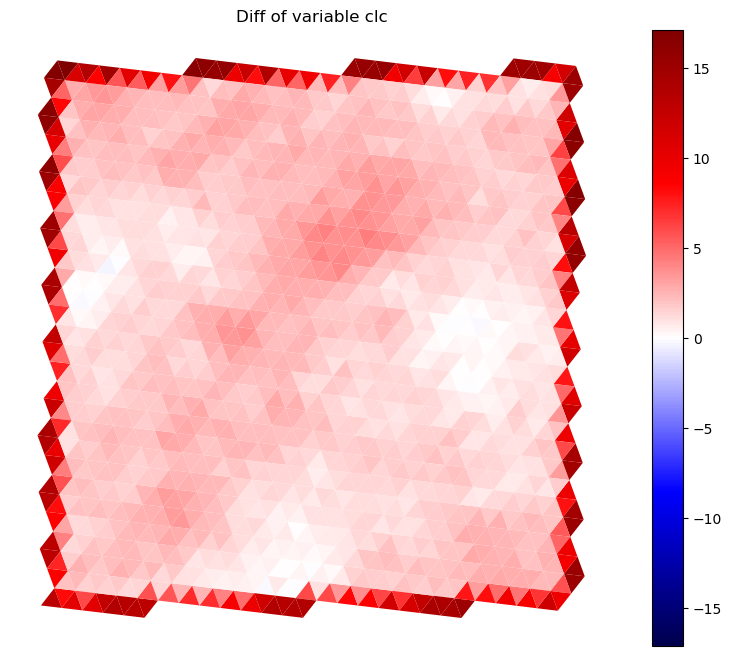

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

values = mean_diff_gdf[f"{diff_col}_avg"]
absmax = max(abs(values.min()), abs(values.max()))

mean_diff_gdf.plot(
    column=f"{diff_col}_avg",
    cmap="seismic",
    legend=True,
    ax=ax,
    vmin=-absmax,   
    vmax= absmax
)

ax.set_title(f"Diff of variable {var}")
ax.set_axis_off()
plt.show()

In [17]:
grouped

,cell_id,clc_diff,geometry
0,9938,15.283967,"POLYGON ((10.87165 46.73132, 10.86882 46.73661..."
1,9940,15.265203,"POLYGON ((10.86882 46.73661, 10.87410 46.74124..."
2,9941,9.262431,"POLYGON ((10.86882 46.73661, 10.86598 46.74191..."
3,9942,2.475316,"POLYGON ((10.86882 46.73661, 10.86070 46.73729..."
4,9943,2.338638,"POLYGON ((10.86353 46.73199, 10.85542 46.73266..."
...,...,...,...
1463,27521,13.709003,"POLYGON ((10.76653 46.72480, 10.76368 46.73009..."
1464,27522,13.521255,"POLYGON ((10.76368 46.73009, 10.76653 46.72480..."
1465,27527,13.429755,"POLYGON ((10.75557 46.73076, 10.76368 46.73009..."
1466,27528,13.644303,"POLYGON ((10.75557 46.73076, 10.75841 46.72546..."


In [18]:
mean_diff_gdf.to_file('output_clc.geojson', driver="GeoJSON")